### The Mectron Load Line

In this notebook, we'll explore load line placement using extracted data from the 25L6G plate characteristic curves. The interactive example allows changing Ia, Va, n and speaker impedance while drawing and calculating output performance estimations.

The code then determines the transfer characteristic from the selected operating point and extracted data. It then calculates the circuit transient response highlighting second harmonic distortion. Finally, the user can play 3 normalized audio levels with varying levels of second harmonic to demonstrate what a distorted sine wave sounds like.
<hr>
<b>Mectron MPA-II Schematic</b><br>
<img src='../mpa-ii-schematic.jpg'><br>
<br><b>25L6GT</b><br>
<img src='25L6GT EC2=110V.png'>
<hr>
#### Data Extraction

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
from scipy import interpolate
import math
from ipywidgets import *
from scipy.fftpack import fft

# used engauge to extract plot data from datasheet
fn = "25L6GT EC2=110V.csv"
df = pd.read_csv(fn)

/home/holla/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
df.head(5)

,AnodeVoltage,0V,-2V,-4V,-6V,-8V,-10V,-12V,-14V,-16V
0,-5.000000e-15,0.00035,-0.00034,-0.00069,0.00035,0.00241,0.00034,-0.00069,0.00414,-0.00034
1,6.900000e-01,0.00035,0.00375,-0.00069,0.00035,0.00241,0.00368,0.00653,0.00414,-0.00034
2,1.370000e+00,0.00883,0.00777,0.00283,0.00454,0.00241,0.00685,0.00832,0.00414,0.00090
3,2.060000e+00,0.01496,0.01163,0.00631,0.00861,0.00938,0.00970,0.00931,0.00414,0.00155
4,2.750000e+00,0.01925,0.01529,0.00972,0.01245,0.01287,0.01214,0.00994,0.00414,0.00194


In [3]:
df.tail(5)

,AnodeVoltage,0V,-2V,-4V,-6V,-8V,-10V,-12V,-14V,-16V
197,468.41,0.15476,0.12649,0.09892,0.07548,0.05514,0.03756,0.02549,0.01520,0.00766
198,474.27,0.15476,0.12649,0.09892,0.07548,0.05514,0.03756,0.02528,0.01510,0.00760
199,477.34,0.15476,0.12649,0.09892,0.07548,0.05514,0.03756,0.02516,0.01504,0.00756
200,486.95,0.15476,0.12649,0.09892,0.07548,0.05514,0.03756,0.02516,0.01482,0.00738
201,493.82,0.15476,0.12649,0.09892,0.07548,0.05514,0.03756,0.02516,0.01482,0.00724


<hr>
#### Load Line Placement

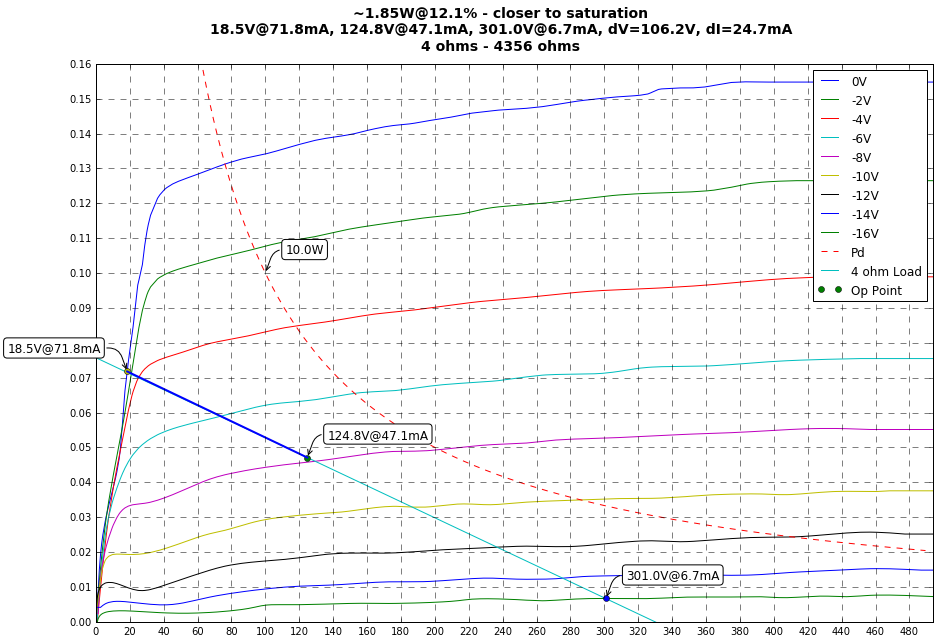

In [4]:
#initial values
Ia = 0.0471  #plate current mA
Va = 126.6   #plate voltage V
Rl = 4       #speaker impedance
n  = 33      #pri/sec turns ratio

# later, we find intersection of loadline with plate current curves by resampling
# so all have the same x values.
# http://stackoverflow.com/questions/17928452/find-all-intersections-of-xy-data-point-graph-with-numpy
# http://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html
va = np.arange(0, 490,0.5)
ia0f = interpolate.interp1d(df['AnodeVoltage'].tolist(), df['0V'].tolist())
ia16f = interpolate.interp1d(df['AnodeVoltage'].tolist(), df['-16V'].tolist())
ia0 = ia0f(va)
ia16 = ia16f(va)
colnames = df.columns.values
rowcount = len(df[colnames[0]])

i0intersect = 0
i16intersect = 0

def plot(_Ia,_Va,_Rl,_n):
    global i0intersect, i16intersect,Ia,Va,Rl,n
    Ia = _Ia # set the slider values to global
    Va = _Va
    Rl = _Rl
    n  = _n
    # plot the csv colums versus plate/anode voltage
    fig = plt.figure(figsize=(15, 10))
    null = [plt.plot(df[colnames[0]],df[colnames[x]],label=colnames[x]) for x in range(1,len(colnames))]
    plt.grid(linestyle='--', linewidth=0.5)
    null = plt.xticks(np.arange(0,520,20))
    null = plt.yticks(np.arange(0,0.201,0.01))

    # plot power dissipation limit curve
    Pd = 10 # 10W
    null = plt.plot(va, Pd/va,label='Pd',linestyle='--')
    plt.ylim(0,0.16)
    
    null = plt.annotate(s="%.1fW"%(Pd),
                    xy=(100,Pd/100.0),
                    xycoords='data',
                    xytext=(20,20),
                    textcoords='offset points',
                    bbox=dict(boxstyle="round", fc="1.0"),
                    size=12,
                    arrowprops=dict(arrowstyle="->",
                                    connectionstyle="angle,angleA=0,angleB=70,rad=10"))



    plateImpedance = float(Rl * n**2)

    m = -1/plateImpedance
    b = Ia + Va/plateImpedance
    ll = m*va+b

    null = plt.plot(va,ll,label='%d ohm Load'%Rl)
    null = plt.plot(Va,Ia, 'or',label='Op Point',color='g')

    ll = m*va+b

    mindiff = 10
    for v in va:
        diff = abs(ia0f(v)-(m*v+b))
        if diff < mindiff:
            v0intersect = v
            mindiff = diff

    mindiff = 10
    for v in va:
        diff = abs(ia16f(v)-(m*v+b))
        if diff < mindiff:
            v16intersect = v
            mindiff = diff

    i0intersect = ia0f(v0intersect)
    i16intersect = ia16f(v16intersect)
    
    # from RCA RC-22 P19
    distortion = (((i16intersect+i0intersect)/2 - Ia)/(i16intersect-i0intersect))*100
    
    null = plt.plot(v0intersect,i0intersect,'or',color='y')
    null = plt.plot(v16intersect,i16intersect,'or',color='b')
    
    dvlower = Va - v0intersect
    dilower = i0intersect - Ia
    dvhigher = v16intersect - Va
    dihigher = Ia - i16intersect
       
    if dvlower < dvhigher:
        # closer to saturation
        Pout =  dvlower*(1/math.sqrt(2))*dilower
        title = "~%.2fW@%0.1f%% - closer to saturation\n%.1fV@%.1fmA, %.1fV@%.1fmA, %.1fV@%.1fmA, dV=%.1fV, dI=%.1fmA\n%d ohms - %d ohms"%(Pout,
                                                                            distortion,
                                                                            v0intersect,i0intersect*1000,
                                                                            Va,Ia*1000,
                                                                            v16intersect,i16intersect*1000,
                                                                            dvlower,dilower*1000,
                                                                            Rl,
                                                                            plateImpedance)
        null = plt.plot((v0intersect,Va),(i0intersect,Ia),linewidth=2,color='b')
    else:
        # closer to cutoff
        Pout =  (v16intersect-Va)*(1/math.sqrt(2))*(Ia-i16intersect)
        title = "~%.2fW@%0.1f%% - closer to cutoff\n%.1fV@%.1fmA, %.1fV@%.1fmA, %.1fV@%.1fmA, dV=%.1fV, dI=%.1fmA\n%d ohms - %d ohms"%(Pout,
                                                                        distortion,
                                                                        v0intersect,i0intersect*1000,
                                                                        Va,Ia*1000,
                                                                        v16intersect,i16intersect*1000,
                                                                        dvhigher,dihigher*1000,
                                                                        Rl,
                                                                        plateImpedance)
        null = plt.plot((Va,v16intersect),(Ia,i16intersect),linewidth=2,color='b')

    null = plt.annotate(s="%.1fV@%.1fmA"%(v0intersect,i0intersect*1000),
                        xy=(v0intersect,i0intersect),
                        xycoords='data',
                        xytext=(-120,20),
                        textcoords='offset points',
                        bbox=dict(boxstyle="round", fc="1.0"),
                        size=12,
                        arrowprops=dict(arrowstyle="->",
                                        connectionstyle="angle,angleA=0,angleB=110,rad=10"))
    null = plt.annotate(s="%.1fV@%.1fmA"%(Va,Ia*1000),
                        xy=(Va,Ia),
                        xycoords='data',
                        xytext=(20,20),
                        textcoords='offset points',
                        bbox=dict(boxstyle="round", fc="1.0"),
                        size=12,
                        arrowprops=dict(arrowstyle="->",
                                        connectionstyle="angle,angleA=0,angleB=70,rad=10"))
    null = plt.annotate(s="%.1fV@%.1fmA"%(v16intersect,i16intersect*1000),
                        xy=(v16intersect,i16intersect),
                        xycoords='data',
                        xytext=(20,20),
                        textcoords='offset points',
                        bbox=dict(boxstyle="round", fc="1.0"),
                        size=12,
                        arrowprops=dict(arrowstyle="->",
                                        connectionstyle="angle,angleA=0,angleB=70,rad=10"))
    plt.suptitle(title,fontsize=14, fontweight='bold')
    plt.legend()

null = interact(plot,
             _Ia=widgets.FloatSlider(min=0.01,max=0.1,step=0.0025,value=Ia),
             _Va=widgets.FloatSlider(min=50,max=300,step=5,value=124.75),
             _Rl=widgets.FloatSlider(min=2,max=16,step=2,value=4),
             _n=widgets.FloatSlider(min=10,max=40,step=1,value=33))

From RCA RC-22, p19,
$$THD\% = \large{\frac{\frac{I_{max}+I_{min}}{2}-I_O}{I_{max}-I_{min}} * 100}$$
<hr>
### Moving on to the transfer characteristic, transient response and harmonic content

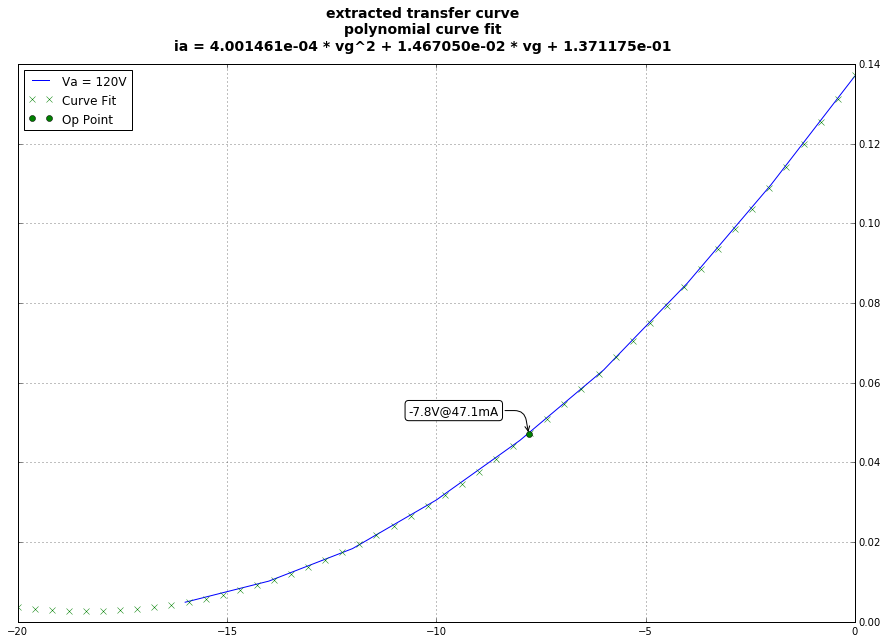

In [5]:
from scipy.optimize import fsolve
x = []
for c in range(1,len(colnames)):
    x.append(float(colnames[c][:-1]))

fig = plt.figure(figsize=(15, 10))

for r in range(0,rowcount):
    if abs(df['AnodeVoltage'][r] - Va) < 5:
        y = []
        for c in range(1,len(colnames)):
            y.append(df[colnames[c]][r])
        plt.plot(x,y,label="Va = %.0fV"%df[colnames[0]][r])
        break
        
plt.tick_params(axis='y', which='both', labelleft='off', labelright='on')
plt.grid(True)

'''
for i in range(len(x)):
    print "%.6f,%0.6f"%(x[i],y[i])
'''

coeff = np.polyfit(x, y, 2)

def func(x):
    global coeff,Ia
    return coeff[0]*x*x+coeff[1]*x+coeff[2] - Ia

title = "extracted transfer curve\npolynomial curve fit\nia = %0.6e * vg^2 + %0.6e * vg + %0.6e"%(coeff[0],coeff[1],coeff[2])

x = np.linspace(-20,0)
null = plt.plot(x,coeff[0]*x*x+coeff[1]*x+coeff[2],marker='x',label="Curve Fit",linestyle='None')

# using the curve-fitted curve, find Vg at Ia
Vg = fsolve(func,8.0)

null = plt.annotate(s="%.1fV@%.1fmA"%(Vg,Ia*1000),
                        xy=(Vg,Ia),
                        xycoords='data',
                        xytext=(-120,20),
                        textcoords='offset points',
                        bbox=dict(boxstyle="round", fc="1.0"),
                        size=12,
                        arrowprops=dict(arrowstyle="->",
                                        connectionstyle="angle,angleA=0,angleB=100,rad=10"))

null = plt.plot(Vg,Ia, 'or',label='Op Point',color='g')
null = plt.suptitle(title,fontsize=14, fontweight='bold')

null = plt.legend(loc='upper left')


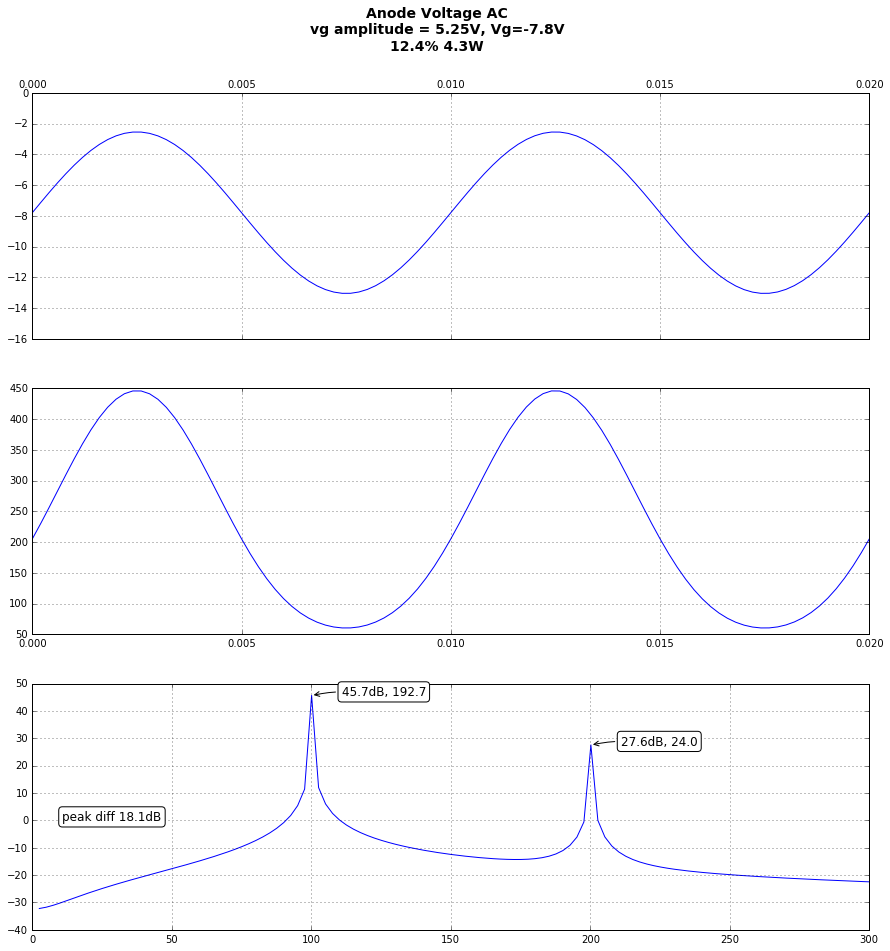

In [6]:
from scipy import signal
def plotTransient(vgamplitude):
    ra = Rl*n*n

    N = 2000
    T = 1.0 / 5000.0
    f = 100.0

    t = np.linspace(0.0, N*T, N)
    vi = Vg + vgamplitude*np.sin(f*2.0*np.pi*t)
    ia = coeff[0]*vi*vi + coeff[1]*vi + coeff[2]
    vo = ia*ra

    yf = fft(vo)
    xf = np.linspace(0.0, 1.0/(2.0*T), N/2)

    plt.figure(figsize=(15, 15))

    ax = plt.subplot(311)
    null = plt.xlim([0,0.02])
    null = plt.ylim([-16,0])
    ax.plot(t,vi)
    ax.grid(True)
    ax.tick_params(axis='x', which='both', labeltop='on',labelbottom='off')

    ax = plt.subplot(312)
    null = plt.xlim([0,0.02])
    # null = plt.ylim([0,600])
    ax.plot(t,vo)
    ax.grid(True)
    
    ax = plt.subplot(313)
    yfl = 2.0/N * np.abs(yf[:N/2])
    ax.plot(xf[1:], 20*np.log10(yfl[1:])) # take the dc component off
    null = plt.xlim([0,300])
    ax.grid(True)
     
    mags = []
    for i in range(len(xf)):
        if xf[i]%100 < 1:
            mags.append(2.0/N*np.abs(yf[i]))
            # print xf[i],2.0/N*np.abs(yf[i])

    sum = 0
    for i in range(2,8):
        sum += mags[i]*mags[i]

    dist = 100*math.sqrt(sum)/mags[1]
    power = math.pow((mags[1]/n)/math.sqrt(2),2)/Rl

    null = plt.suptitle("Anode Voltage AC\nvg amplitude = %.2fV, Vg=%.1fV\n%.1f%% %.1fW"%(vgamplitude,Vg,dist,power),fontsize=14, fontweight='bold')

    peakind = signal.find_peaks_cwt(20*np.log10(yfl), np.arange(1,10))
    # print peakind, xf[peakind], yfl[peakind]
    
    # the peaks are off by 1 for some reason
    i1 = peakind[0]-1
    p1 = yfl[i1]
    p1l = 20 * np.log10(p1)
    
    i2 = peakind[1]-1
    p2 = np.abs(yfl[i2])
    p2l = 20 * np.log10(p2)
    
    null = plt.annotate(s="%.1fdB, %.1f"%(p1l,p1),
                xy=(xf[i1],p1l),
                xycoords='data',
                xytext=(30,0),
                textcoords='offset points',
                bbox=dict(boxstyle="round", fc="1.0"),
                size=12,
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="angle,angleA=0,angleB=10,rad=10"))
    null = plt.annotate(s="%.1fdB, %.1f"%(p2l,p2),
                xy=(xf[i2],p2l),
                xycoords='data',
                xytext=(30,0),
                textcoords='offset points',
                bbox=dict(boxstyle="round", fc="1.0"),
                size=12,
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="angle,angleA=0,angleB=10,rad=10"))

    null = plt.annotate(s="peak diff %.1fdB"%(abs(p1l-p2l)),
                xy=(0,0),
                xycoords='data',
                xytext=(30,0),
                textcoords='offset points',
                bbox=dict(boxstyle="round", fc="1.0"),
                size=12)

    plt.show()
  
    
null = interact(plotTransient, vgamplitude=widgets.FloatSlider(min=0,max=8,step=0.25,value=1))

In [7]:
from IPython.display import HTML

# references
#   https://jakevdp.github.io/blog/2013/06/01/ipython-notebook-javascript-python-communication/
#   https://github.com/mdn/audio-buffer/blob/gh-pages/index.html
    
javascript = """
<script>
    var audioCtx = new (window.AudioContext || window.webkitAudioContext)();
    var pre = document.querySelector('pre');
    var myScript = document.querySelector('script');

    var channels = 2;
    var frameCount = audioCtx.sampleRate * 5.0;

    var myArrayBuffer = audioCtx.createBuffer(channels, frameCount, audioCtx.sampleRate);
    var play = function(Vg,vgamplitude,Ia,a0,a1,a2,gain) {
      console.log(Vg,vgamplitude,Ia,a0,a1,a2)
      for (var channel = 0; channel < channels; channel++) {
       // This gives us the actual array that contains the data
       var nowBuffering = myArrayBuffer.getChannelData(channel);
       for (var i = 0; i < frameCount; i++) {
         // audio needs to be in [-1.0; 1.0]
         vi = Vg + vgamplitude*Math.sin(50*3.14*i);
         nowBuffering[i] = gain*((a0*vi*vi + a1*vi + a2)-Ia);
       }
      }

      var source = audioCtx.createBufferSource();
      source.buffer = myArrayBuffer;
      source.connect(audioCtx.destination);
      source.start();
    }
  </script>
"""

HTML(javascript)

In [8]:
# these 3 js buttons call the play function with Vg,vgamplitude,Ia,a0,a1,a2,gain where gain
# is set so fundamental has same amplitude, i.e. close to same loudness, so the user speaker
# amplifer doesn't distort and taint resulting audio.
# I use https://play.google.com/store/apps/details?id=com.zephyr.soundAnalyserPRO for spectrum
# display

input_form = """
<button onclick='play(%f,%f,%f,%f,%f,%f,%f)' style="width:200px">Play vg=0.1Vpp</button><br>
<button onclick='play(%f,%f,%f,%f,%f,%f,%f)' style="width:200px">Play vg=4pp</button><br>
<button onclick='play(%f,%f,%f,%f,%f,%f,%f)' style="width:200px">Play vg=8pp</button><br>
<div id='buf'><div>
"""%(Vg,0.1,Ia,coeff[0],coeff[1],coeff[2],80,Vg,4,Ia,coeff[0],coeff[1],coeff[2],2,Vg,8,Ia,coeff[0],coeff[1],coeff[2],1)
HTML(input_form)

<hr>
<a href='https://play.google.com/store/apps/details?id=com.zephyr.soundAnalyserPRO'>Sound Analyser PRO</a><br>
<img src="../soundanalyser.png"/>

### References
#### Load Line
 * <a href='http://www.valvewizard.co.uk/se.html'>The Valve Wizard - The Single Ended Output Stage</a>
 * <a href='http://www.blueguitar.org/new/text/threads/from_mark/SBench_Loadlines_Series.pdf'>Steve Bench - Of Loadlines, Power Output and Distortion</a>

#### Harmonic Distortion Calculation
 * <a href='https://youtu.be/gMkSmlv9XbE?t=19m43s'>Tube Theory part 3 - Dennis Carter</a>
 * <a href='http://www.g8wrb.org/data//RCA/RC-22-Receiving-Tube-Manual.pdf'>RCA Receiving Tube Manual RC-22, p19</a>
 * <a href='http://www.tubebooks.org/Books/intro_reich.pdf'>Theory and Applications of Electron tubes - Reich, Section 3-20, p74 / Section 4-18, p115</a>